In [5]:

import json
import pandas as pd
import numpy as np
from toolz import memoize
import datetime
import math

from tqdm import tqdm
from src.utils.mouselab_jas import MouselabJas
from src.utils.distributions import Normal, expectation
from src.utils.env_creation import create_tree, create_init
from src.utils.env_export import create_json
from src.utils.data_classes import MouselabConfig, Action
from simulation import run_simulation
from src.policy.jas_voc_policy import JAS_voc_policy
from src.policy.jas_policy import RandomPolicy, ExhaustivePolicy, RandomNPolicy
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from src.utils.utils import sigma_to_tau
import numpy as np
from src.utils.env_export import format_payoff


sns.set(rc={'figure.figsize':(10,6)})
sns.set(font_scale=1.5)
sns.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
data = json.load(open("./data/dataclips_3.json"))

In [7]:
language_index = data["fields"].index("language")
response_data_index = data["fields"].index("datastring")
begin_index = data["fields"].index("beginhit")
end_index = data["fields"].index("endhit")

f = '%Y-%m-%d %H:%M:%S.%f'

In [4]:
# Fixed from paper
num_projects = 5
num_criteria = 6
weights = [0.0206795, 0.0672084, 0.2227102, 0.1067428, 0.4665054, 0.1161537]
expert_stds = [1.5616618964384956, 1.449172525995787, 1.5205992970609392, 1.5469422429523034, 1.511270787760881, 1.455189251463794]
expert_taus = list(sigma_to_tau(np.array(expert_stds)))

mu = [3.6, 3.1666666666666665, 3.6, 3.1333333333333333, 3.6666666666666665, 2.3]
sigma = [1.3544307876819288, 1.2617266038997932, 1.3796551293211172, 1.2521246311585852, 1.5161960871578068, 0.9523111632886272]

init = create_init([0]+(mu*num_projects), [0]+(sigma*num_projects))
expert_costs = [0.002]*6

config = MouselabConfig(num_projects, num_criteria, expert_costs, expert_taus, init, criteria_scale=weights, term_belief=False, max_actions=5)
env = MouselabJas(config=config)
voc_policy = JAS_voc_policy(discrete_observations=True, cost_weight=0.5798921379230035)

In [18]:
def convert_action(project: int, criteria: int, expert: int, config: MouselabConfig) -> Action:
    query = (1 + criteria) + project*config.num_criterias
    action = Action(expert=expert, query=query)
    return action

In [19]:
df_index = ["Participant", "TrialId", "Score", "ExpectedScore", "NumClicks", "Actions", "Selection",
        "Seed", "ClickAgreement"]    
df_data = []

bonus_data = {}
known_workers = []
good_responses = 0
demographics = []

participant_actions = []

# Parse raw mturk data into dataframe
for p_index, p_data in tqdm(enumerate(data["values"])):
    # Filter out empty responses
    language = p_data[language_index]
    response_data = p_data[response_data_index]
    if p_data[begin_index] and p_data[end_index]:
        begin = datetime.datetime.strptime(p_data[begin_index], f)
        end = datetime.datetime.strptime(p_data[end_index], f)
        duration = (end - begin).total_seconds()
    else:
        duration = None
    if (response_data != None):
        p_res_obj = json.loads(response_data)
        if (not p_res_obj["workerId"].startswith("debug")):
            condition = p_res_obj["condition"]
            worker = p_index # p_res_obj["workerId"]#
            if worker in known_workers:
                print("Duplicate worker", worker)
            else: 
                known_workers.append(worker)
            p_res = p_res_obj["data"]
            participant_responses = []
            if "quiz_failures" in p_res_obj["questiondata"].keys():
                quiz_failures = p_res_obj["questiondata"]["quiz_failures"]
            else:
                quiz_failures = 0
            if "final_bonus" in p_res_obj["questiondata"].keys():
                bonus =  p_res_obj["questiondata"]["final_bonus"]
            else:
                bonus = 0
            participant_survey = {"Participant": worker, "Condition": condition, "Language": language, "QuizAttempts": 0, "QuizFailures": quiz_failures, "Bonus": bonus, "Duration": duration}
            completed_test_trials = sum([1 if ('trial_id' in  p_res[i]['trialdata'].keys() and p_res[i]['trialdata']['trial_id'].startswith("test")) else 0 for i in range(len(p_res))])
            if (quiz_failures < 3) and (completed_test_trials == 10):
                for i in range(len(p_res)):
                    # Get test trials
                    if 'trial_id' in p_res[i]['trialdata'].keys() and p_res[i]['trialdata']['trial_id'].startswith("test"):
                        trial_id = p_res[i]['trialdata']['trial_id']
                        seed = int(p_res[i]['trialdata']['seed'])
                        ground_truth = p_res[i]['trialdata']['ground_truth']
                        # project, criteria, expert
                        clicks = p_res[i]['trialdata']["clicks"]
                        num_clicks = len(clicks)
                        selected_project = p_res[i]['trialdata']["selected_project"]
                        term_reward = p_res[i]['trialdata']["reward"]
                        expected_reward = p_res[i]['trialdata']["expected_reward"]
                        # Calculate real env rewards
                        env.reset(seed=seed)
                        actions = [convert_action(*click, config) for click in clicks]
                        participant_actions.extend(actions)
                        cost = 0
                        # Click agreement
                        click_agreement = []
                        for action in actions:
                            optimal_actions = voc_policy.get_best_actions(env)
                            if action in optimal_actions:
                                click_agreement.append(1)
                            else:
                                click_agreement.append(0)
                            _, reward, _, _ = env.step(action)
                            cost += reward
                        optimal_actions = voc_policy.get_best_actions(env)
                        if env.term_action in optimal_actions:
                            click_agreement.append(1)
                        else:
                            click_agreement.append(0)
                        path = np.array(range(1, config.num_criterias+1))+(selected_project*config.num_criterias)
                        env_expected_reward = cost + env.expected_path_value(path, env.state)
                        env_term_reward = cost + env.path_value(path)
                        assert np.all(np.isclose(ground_truth, env.ground_truth.tolist()))
                        assert np.all(np.isclose(np.array(format_payoff(config.num_projects, config.num_criterias, env.expert_truths.tolist())), p_res[i]['trialdata']['payoff_matrix']))
                        assert np.isclose(term_reward, env_term_reward)
                        assert np.isclose(expected_reward, env_expected_reward)
                        
                        #["Participant", "TrialId", "Score", "ExpectedScore", "NumClicks", "Actions", "Selection", "Seed"] 
                        df_data.append([worker, trial_id, term_reward, expected_reward, num_clicks, clicks, selected_project, seed, np.mean(click_agreement)])
                    elif 'trial_id' in p_res[i]['trialdata'].keys() and p_res[i]['trialdata']['trial_id'].startswith("train"):
                        pass
                    elif p_res[i]['trialdata']["trial_type"] == "survey-text":
                        #print(p_res[i]['trialdata'].keys())
                        print(p_res[i]['trialdata']["response"])
                        for key, val in p_res[i]['trialdata'].items():
                            pass
                            #print(key, val)
                    

df = pd.DataFrame(df_data, columns=df_index)
print("Responses:", len(df["Participant"].unique()))

1it [00:08,  8.85s/it]

{'Age': '59', 'Gender': 'Female', 'Issues': 'None', 'Feedback': ''}


2it [00:16,  8.09s/it]

{'Age': '21', 'Gender': 'Male', 'Issues': '', 'Feedback': ''}


3it [00:23,  7.51s/it]

{'Age': '38', 'Gender': 'Male', 'Issues': 'None', 'Feedback': 'None'}


4it [00:25,  5.26s/it]

{'Age': '29', 'Gender': 'Male', 'Issues': 'No', 'Feedback': 'None'}


5it [00:31,  5.75s/it]

{'Age': '21', 'Gender': 'Male', 'Issues': 'No issues', 'Feedback': '-'}


6it [00:39,  6.30s/it]

{'Age': '23', 'Gender': 'male', 'Issues': '', 'Feedback': ''}


10it [00:42,  2.67s/it]

{'Age': '47', 'Gender': 'male', 'Issues': 'no', 'Feedback': ''}


12it [01:01,  4.95s/it]

{'Age': '20', 'Gender': 'Male', 'Issues': 'No it was smoooth sailing for me', 'Feedback': 'It was cool. The thrill of uncertity made it more fun like roullete'}


13it [01:16,  6.74s/it]

{'Age': '20', 'Gender': 'female', 'Issues': '', 'Feedback': ''}


14it [01:23,  6.75s/it]

{'Age': '25', 'Gender': 'FEMALE', 'Issues': 'NO', 'Feedback': 'IT WAS AMAZING'}


16it [01:29,  5.37s/it]

{'Age': '32', 'Gender': 'Female', 'Issues': 'None', 'Feedback': 'None'}


17it [01:53,  9.43s/it]

{'Age': '36', 'Gender': 'female', 'Issues': 'no', 'Feedback': ''}


18it [02:15, 12.30s/it]

{'Age': '25', 'Gender': 'female', 'Issues': 'no', 'Feedback': 'none'}


19it [02:33, 13.75s/it]

{'Age': '20', 'Gender': 'Male', 'Issues': 'No', 'Feedback': 'N/A'}


20it [03:01, 17.29s/it]

{'Age': '45', 'Gender': 'Male', 'Issues': 'no', 'Feedback': ''}


22it [03:20, 13.96s/it]

{'Age': '22', 'Gender': 'male', 'Issues': 'no', 'Feedback': ''}


23it [03:27, 12.49s/it]

{'Age': '40', 'Gender': 'female', 'Issues': 'no', 'Feedback': ''}


30it [03:49,  5.92s/it]

{'Age': '27', 'Gender': 'Male', 'Issues': 'No', 'Feedback': 'None'}


31it [04:05,  7.18s/it]

{'Age': '26', 'Gender': 'FEMALE', 'Issues': 'NO', 'Feedback': 'NO'}


32it [04:10,  6.80s/it]

{'Age': '24', 'Gender': 'female', 'Issues': 'yes', 'Feedback': 'improve your imstriclk\n'}


34it [04:36,  8.68s/it]

{'Age': '25', 'Gender': 'Man', 'Issues': 'No issues.', 'Feedback': ''}


35it [04:42,  8.24s/it]

{'Age': '37', 'Gender': 'MAle', 'Issues': 'No issue', 'Feedback': 'Good luck with the experiment'}


36it [05:11, 12.42s/it]

{'Age': '57', 'Gender': 'Male', 'Issues': 'No.', 'Feedback': 'I noticed the identical nature of the scores and chose from the experts who appeared to have the highest star ratings. I sought their advice on the one factor with the largest scaleability.'}


37it [05:18, 11.33s/it]

{'Age': '30', 'Gender': 'Male', 'Issues': 'No. ', 'Feedback': ''}


39it [05:36, 10.26s/it]

{'Age': '23', 'Gender': 'Male', 'Issues': 'None', 'Feedback': 'The variables were too randomized and tools too powerless to make me do anything beyond educated guesses, but I imagine that was the scope of the experiment. So no complaints.'}


40it [05:39,  8.73s/it]

{'Age': '25', 'Gender': 'F', 'Issues': 'No', 'Feedback': 'No'}


41it [05:50,  9.35s/it]

{'Age': '32', 'Gender': 'male', 'Issues': 'no', 'Feedback': ''}


42it [06:10, 11.98s/it]

{'Age': '31', 'Gender': 'female', 'Issues': 'no', 'Feedback': 'thank you'}


43it [06:15, 10.18s/it]

{'Age': '44', 'Gender': 'Female', 'Issues': 'No', 'Feedback': ''}


44it [06:35, 12.97s/it]

{'Age': '33', 'Gender': 'Male', 'Issues': 'None', 'Feedback': 'None'}


46it [06:42,  8.78s/it]

{'Age': '58', 'Gender': 'Female', 'Issues': 'No ', 'Feedback': ''}


47it [07:11, 13.52s/it]

{'Age': '18', 'Gender': 'Male', 'Issues': 'No', 'Feedback': ''}


48it [07:38, 16.99s/it]

{'Age': '27', 'Gender': 'Male', 'Issues': '', 'Feedback': ''}


49it [07:44, 13.92s/it]

{'Age': '21', 'Gender': 'Female', 'Issues': 'No', 'Feedback': 'No'}


50it [08:04, 15.67s/it]

{'Age': '36', 'Gender': 'woman', 'Issues': 'no', 'Feedback': ''}


51it [08:29, 18.43s/it]

{'Age': '29', 'Gender': 'male', 'Issues': 'no', 'Feedback': '-'}


52it [08:56, 20.78s/it]

{'Age': '24', 'Gender': 'Female', 'Issues': 'Nope, it was well constructed and clear ', 'Feedback': 'Great game!'}


53it [09:23, 22.73s/it]

{'Age': '20', 'Gender': 'Male', 'Issues': 'No', 'Feedback': ''}


54it [09:49, 23.72s/it]

{'Age': '25', 'Gender': 'Male', 'Issues': 'Not really', 'Feedback': 'It was very interesting study <3'}


55it [10:19, 25.50s/it]

{'Age': '22', 'Gender': 'male', 'Issues': 'No', 'Feedback': 'Nice experiment'}


56it [10:47, 26.20s/it]

{'Age': '22', 'Gender': 'Male', 'Issues': 'No issues but I think that instruction could be a little easier to understand ', 'Feedback': ''}


57it [11:10, 25.33s/it]

{'Age': '20', 'Gender': 'Female', 'Issues': 'no', 'Feedback': 'no'}


59it [11:37, 19.89s/it]

{'Age': '22', 'Gender': 'Female', 'Issues': 'No', 'Feedback': 'No'}


60it [12:06, 22.05s/it]

{'Age': '23', 'Gender': 'female', 'Issues': 'no', 'Feedback': 'no'}


61it [12:19, 19.57s/it]

{'Age': '29', 'Gender': 'Male', 'Issues': 'no', 'Feedback': 'no'}


62it [12:26, 16.32s/it]

{'Age': '23', 'Gender': 'male', 'Issues': 'no', 'Feedback': 'no'}


63it [12:29, 12.50s/it]

{'Age': '30', 'Gender': 'female', 'Issues': 'n/a', 'Feedback': 'n/a'}


64it [12:40, 12.00s/it]

{'Age': '25', 'Gender': 'Female', 'Issues': 'No, everything was clear ', 'Feedback': ':)'}


65it [12:50, 11.44s/it]

{'Age': '24', 'Gender': 'female', 'Issues': 'no', 'Feedback': 'suggesting you use "they" instead of "he" when referring to the expert'}


66it [13:01, 11.37s/it]

{'Age': '24', 'Gender': 'female', 'Issues': 'no', 'Feedback': 'thank you for the detailed explanation'}


67it [13:11, 11.07s/it]

{'Age': '43', 'Gender': 'male', 'Issues': 'no', 'Feedback': 'Thank you!'}


68it [13:22, 11.05s/it]

{'Age': '34', 'Gender': 'Male', 'Issues': 'No', 'Feedback': ''}


69it [13:34, 11.32s/it]

{'Age': '22', 'Gender': 'Female', 'Issues': 'no', 'Feedback': ''}


70it [13:45, 11.12s/it]

{'Age': '22', 'Gender': 'Male', 'Issues': 'Not at all', 'Feedback': ' '}


71it [13:52,  9.93s/it]

{'Age': '34', 'Gender': 'female', 'Issues': 'everything was good', 'Feedback': 'thank you, have a good day'}


72it [14:04, 10.56s/it]

{'Age': '24', 'Gender': 'Male', 'Issues': '', 'Feedback': ''}


73it [14:13, 10.01s/it]

{'Age': '23', 'Gender': 'm', 'Issues': '', 'Feedback': ''}


74it [14:15,  7.85s/it]

{'Age': '23', 'Gender': 'female', 'Issues': 'no', 'Feedback': 'no'}


75it [14:22,  7.36s/it]

{'Age': '28', 'Gender': 'Male', 'Issues': 'N/A', 'Feedback': 'N/A'}


78it [14:33,  5.29s/it]

{'Age': '36', 'Gender': 'Male', 'Issues': 'No', 'Feedback': ''}


79it [14:43,  6.39s/it]

{'Age': '26', 'Gender': 'female', 'Issues': '', 'Feedback': 'the study was a bit confusing'}


80it [14:47,  5.69s/it]

{'Age': '25', 'Gender': 'Female', 'Issues': 'no', 'Feedback': 'n/a'}


81it [14:59,  7.30s/it]

{'Age': '26', 'Gender': 'Female', 'Issues': 'No', 'Feedback': 'No'}


82it [15:12,  8.76s/it]

{'Age': '34', 'Gender': 'm', 'Issues': 'no', 'Feedback': 'interesting maths ))'}


83it [15:25, 10.01s/it]

{'Age': '22', 'Gender': 'Male', 'Issues': '', 'Feedback': ''}


86it [15:36,  6.67s/it]

{'Age': '48', 'Gender': 'Male', 'Issues': 'No', 'Feedback': ''}


87it [15:45,  6.99s/it]

{'Age': '23', 'Gender': 'feminine', 'Issues': 'no', 'Feedback': 'no thanks'}


88it [15:57,  8.22s/it]

{'Age': '27', 'Gender': 'female', 'Issues': 'no', 'Feedback': 'none'}


89it [16:09,  9.09s/it]

{'Age': '34', 'Gender': 'Female', 'Issues': 'no', 'Feedback': 'It was an interesting survey'}


90it [16:18,  9.16s/it]

{'Age': '34', 'Gender': 'Male', 'Issues': 'No', 'Feedback': 'Very interesting Experiment'}


91it [16:29,  9.64s/it]

{'Age': '30', 'Gender': 'Female', 'Issues': 'I did not experience any issues', 'Feedback': 'This was a very strange game. I would like to know what sort of information you are able to find out about people.'}


92it [16:36,  8.97s/it]

{'Age': '24', 'Gender': 'Male', 'Issues': 'No', 'Feedback': 'No'}


93it [17:03, 13.89s/it]

{'Age': '20', 'Gender': 'female', 'Issues': 'No, everything was alright.', 'Feedback': 'It was definitely an interesting experiment.'}


96it [17:19,  9.32s/it]

{'Age': '26', 'Gender': 'Female', 'Issues': 'No', 'Feedback': ''}


97it [17:47, 13.17s/it]

{'Age': '44', 'Gender': 'Male', 'Issues': 'No. All inctructions was clear. No issues.', 'Feedback': ''}


98it [18:09, 15.23s/it]

{'Age': '25', 'Gender': 'female', 'Issues': 'no', 'Feedback': 'none'}


99it [18:14, 12.65s/it]

{'Age': '43', 'Gender': 'Female', 'Issues': 'N/A', 'Feedback': 'Difficult game'}


100it [18:39, 15.71s/it]

{'Age': '20', 'Gender': 'Female', 'Issues': 'No', 'Feedback': ''}


101it [19:02, 17.92s/it]

{'Age': '24', 'Gender': 'Female', 'Issues': 'Took time to load', 'Feedback': 'None'}


103it [19:31, 11.37s/it]

{'Age': '27', 'Gender': 'Male', 'Issues': '', 'Feedback': ''}
Responses: 80


In [23]:
df.groupby("Participant").mean()

C:\Users\lheindrich\AppData\Local\Temp\ipykernel_25568\2616027.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("Participant").mean()


,Score,ExpectedScore,NumClicks,Selection,Seed,ClickAgreement
Participant,,,,,,
0,3.935127,3.690650,5.0,2.1,15.5,0.166667
1,3.830818,3.641995,3.4,1.4,15.5,0.033333
2,3.717115,3.598912,2.7,1.0,15.5,0.000000
3,3.459099,3.401164,0.0,2.2,15.5,0.000000
4,3.968477,3.656017,2.8,1.7,15.5,0.066667
...,...,...,...,...,...,...
97,3.706930,3.532166,5.0,1.8,15.5,0.200000
98,3.435311,3.401164,0.0,2.5,15.5,0.000000
99,3.922275,3.715833,5.0,2.4,15.5,0.383333


C:\Users\lheindrich\AppData\Local\Temp\ipykernel_25568\1129004770.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.histplot(df.groupby("Participant").mean(), x="ClickAgreement")


<AxesSubplot: xlabel='ClickAgreement', ylabel='Count'>

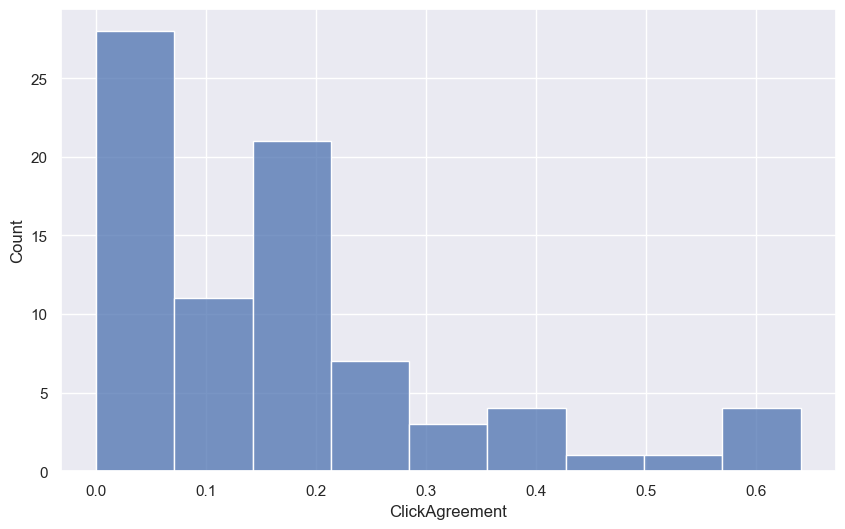

In [24]:
sns.histplot(df.groupby("Participant").mean(), x="ClickAgreement")

In [11]:
# Cost weight 0.5798921379230035 for discrete with max 5 actions
voc_policy = JAS_voc_policy(discrete_observations=True, cost_weight=0.5798921379230035)
res, simulation_actions = run_simulation(env, voc_policy, start_seed=11, n=10)
res = res.drop(["reward", "runtime"], axis=1)
res = res.rename({"actions": "NumClicks", "seed": "Seed", "true_reward": "Score", "expected_reward": "ExpectedScore"}, axis=1)
print(res.agg(["mean", "std"]))
res["Type"] = "MGPO"

  0%|          | 0/10 [00:00<?, ?it/s]

Action(expert=1, query=17) 5.0
Action(expert=5, query=17) 4.0
Action(expert=1, query=11) 3.0
Action(expert=1, query=5) 5.0


 10%|█         | 1/10 [00:00<00:08,  1.06it/s]

Action(expert=5, query=5) 4.0
Action(expert=6, query=31) 0.0
[Action(expert=1, query=17), Action(expert=5, query=17), Action(expert=1, query=11), Action(expert=1, query=5), Action(expert=5, query=5)]
Action(expert=1, query=5) 5.0
Action(expert=5, query=5) 3.0
Action(expert=1, query=23) 4.0


 20%|██        | 2/10 [00:01<00:07,  1.09it/s]

Action(expert=1, query=11) 3.0
Action(expert=1, query=17) 5.0
Action(expert=6, query=31) 0.0
[Action(expert=1, query=5), Action(expert=5, query=5), Action(expert=1, query=23), Action(expert=1, query=11), Action(expert=1, query=17)]
Action(expert=1, query=5) 5.0
Action(expert=5, query=5) 5.0


 30%|███       | 3/10 [00:02<00:05,  1.28it/s]

Action(expert=6, query=31) 0.0
[Action(expert=1, query=5), Action(expert=5, query=5)]
Action(expert=1, query=5) 1.0
Action(expert=1, query=11) 2.0
Action(expert=1, query=29) 3.0


 40%|████      | 4/10 [00:03<00:05,  1.20it/s]

Action(expert=1, query=23) 4.0
Action(expert=1, query=17) 5.0
Action(expert=6, query=31) 0.0
[Action(expert=1, query=5), Action(expert=1, query=11), Action(expert=1, query=29), Action(expert=1, query=23), Action(expert=1, query=17)]
Action(expert=1, query=11) 3.0
Action(expert=1, query=29) 5.0


 50%|█████     | 5/10 [00:04<00:04,  1.24it/s]

Action(expert=5, query=29) 5.0
Action(expert=6, query=31) 0.0
[Action(expert=1, query=11), Action(expert=1, query=29), Action(expert=5, query=29)]
Action(expert=1, query=29) 5.0
Action(expert=5, query=29) 3.0
Action(expert=1, query=23) 3.0


 60%|██████    | 6/10 [00:05<00:03,  1.16it/s]

Action(expert=1, query=5) 4.0
Action(expert=1, query=17) 2.0
Action(expert=6, query=31) 0.0
[Action(expert=1, query=29), Action(expert=5, query=29), Action(expert=1, query=23), Action(expert=1, query=5), Action(expert=1, query=17)]
Action(expert=1, query=29) 4.0
Action(expert=1, query=5) 4.0
Action(expert=1, query=23) 4.0
Action(expert=1, query=11) 5.0


 70%|███████   | 7/10 [00:06<00:02,  1.14it/s]

Action(expert=5, query=11) 5.0
Action(expert=6, query=31) 0.0
[Action(expert=1, query=29), Action(expert=1, query=5), Action(expert=1, query=23), Action(expert=1, query=11), Action(expert=5, query=11)]
Action(expert=1, query=23) 4.0
Action(expert=1, query=29) 5.0
Action(expert=5, query=29) 5.0


 80%|████████  | 8/10 [00:06<00:01,  1.20it/s]

Action(expert=6, query=31) 0.0
[Action(expert=1, query=23), Action(expert=1, query=29), Action(expert=5, query=29)]
Action(expert=1, query=5) 5.0
Action(expert=5, query=5) 1.0
Action(expert=1, query=17) 5.0


 90%|█████████ | 9/10 [00:07<00:00,  1.16it/s]

Action(expert=5, query=17) 5.0
Action(expert=6, query=31) 0.0
[Action(expert=1, query=5), Action(expert=5, query=5), Action(expert=1, query=17), Action(expert=5, query=17)]
Action(expert=1, query=23) 5.0
Action(expert=5, query=23) 5.0


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]

Action(expert=6, query=31) 0.0
[Action(expert=1, query=23), Action(expert=5, query=23)]
      NumClicks      Seed     Score  ExpectedScore
mean   3.900000  15.50000  4.085070       3.751739
std    1.286684   3.02765  0.504705       0.107547


In [23]:
def query_to_criteria(query):
    return (query-1)%config.num_criterias

all_actions = []
for episode in simulation_actions:
    for action in episode:
        all_actions.append([action.expert, query_to_criteria(action.query), action.query, "MGPO"])
for action in participant_actions:
    all_actions.append([action.expert, query_to_criteria(action.query), action.query, "Participant"])


Text(0.5, 1.0, 'Criteria frequency')

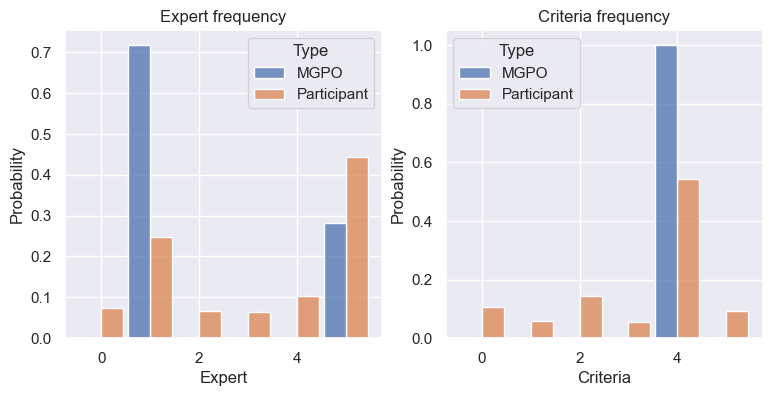

In [24]:
action_df = pd.DataFrame(all_actions, columns=["Expert", "Criteria", "Query", "Type"])

fig, axes =plt.subplots(1,2, figsize=(9,4))
axes = axes.flatten()

g = sns.histplot(action_df, x="Expert", stat="probability", discrete=True, common_bins=True, multiple="dodge", shrink=.9, common_norm = False, hue="Type", ax=axes[0])
g.set_title("Expert frequency")

g = sns.histplot(action_df, x="Criteria", stat="probability", discrete=True, common_bins=True, multiple="dodge", shrink=.9, common_norm = False, hue="Type", ax=axes[1])
g.set_title("Criteria frequency")

### Characteristics of the optimal strategy: 
- Only investigate Criteria 5
- Only ask expert 1 and 5
- If first expert 1 reveals "5", ask expert 5 about the same node
    - If both say "5", terminate
    - Else, ask expert 1 about a different node
- Else, ask expert 1 about a different node

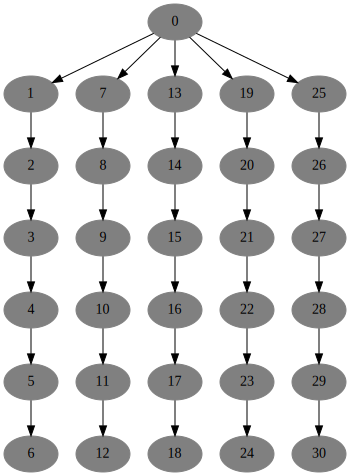

In [73]:
env.reset()
env._render()

In [37]:
participant_res = df[["NumClicks", "Seed", "Score", "ExpectedScore"]].copy()
print(participant_res.agg(["mean", "std"]))
participant_res["Type"] = "Participants"


      NumClicks       Seed     Score  ExpectedScore
mean    3.29750  15.500000  3.681972       3.530881
std     2.02401   2.874078  0.718900       0.187646


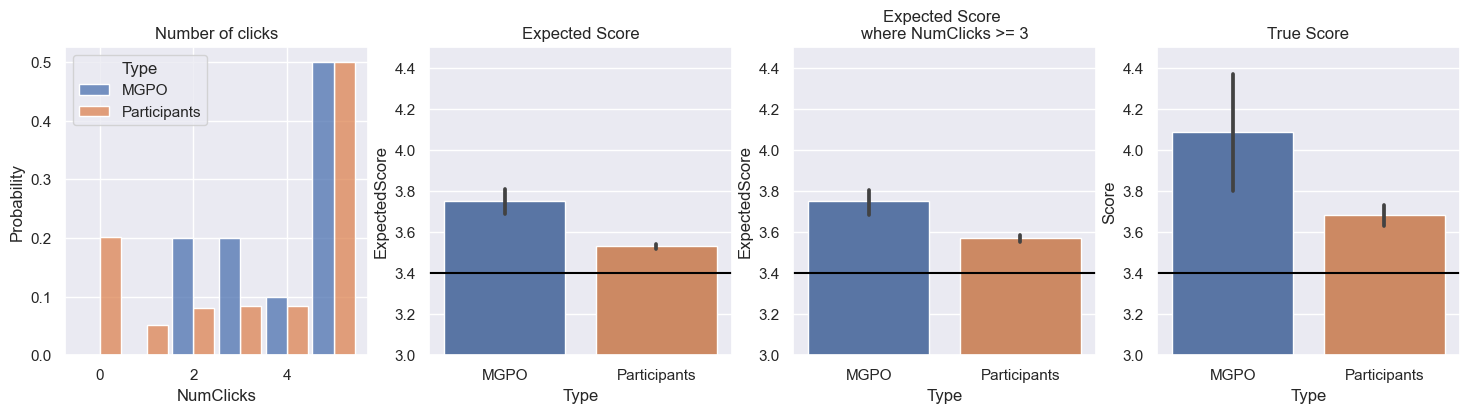

In [65]:
combined_df = pd.concat([res, participant_res])

participant_res_trimmed = participant_res[participant_res["NumClicks"]>=3]
combined_df_trimmed = pd.concat([res, participant_res_trimmed])

fig, axes =plt.subplots(1,4, figsize=(18,4))
axes = axes.flatten()

g = sns.histplot(combined_df, x="NumClicks", stat="probability", discrete=True, common_bins=True, multiple="dodge", shrink=.9, common_norm = False, hue="Type", ax=axes[0])
g.set_title("Number of clicks")
env.reset()

g = sns.barplot(combined_df, y="ExpectedScore", x="Type", ax=axes[1])
g.set_ylim(3,4.5)
g.axhline(env.expected_term_reward(env.state), color="black")
g.set_title("Expected Score")

g = sns.barplot(combined_df_trimmed, y="ExpectedScore", x="Type", ax=axes[2])
g.set_ylim(3,4.5)
g.axhline(env.expected_term_reward(env.state), color="black")
g.set_title("Expected Score \nwhere NumClicks >= 3")

g = sns.barplot(combined_df, y="Score", x="Type", ax=axes[3])
g.set_ylim(3,4.5)
g.axhline(env.expected_term_reward(env.state), color="black")
g.set_title("True Score")

plt.show()

In [9]:
participant_scores = df.groupby("Participant").agg(["mean", "std"])

C:\Users\lheindrich\AppData\Local\Temp\ipykernel_23832\1370106099.py:1: FutureWarning: ['TrialId', 'Actions'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  participant_scores = df.groupby("Participant").agg(["mean", "std"])


In [16]:
participant_scores

Score           ExpectedScore           NumClicks            \
                 mean       std          mean       std      mean       std   
Participant                                                                   
0            3.935127  0.444445      3.690650  0.076789       5.0  0.000000   
1            3.830818  0.600608      3.641995  0.189835       3.4  1.173788   
2            3.717115  0.653587      3.598912  0.131987       2.7  0.823273   
3            3.459099  0.538862      3.401164  0.000000       0.0  0.000000   
4            3.968477  0.634093      3.656017  0.106005       2.8  1.316561   
...               ...       ...           ...       ...       ...       ...   
97           3.706930  0.909851      3.532166  0.320513       5.0  0.000000   
98           3.435311  1.038284      3.401164  0.000000       0.0  0.000000   
99           3.922275  0.470476      3.715833  0.000621       5.0  0.000000   
100          3.709821  0.584997      3.445381  0.146048       4.0  2.108185   
101          3.941252  0.230875      3.626980  0.168627       4.9  0.316228   

            Selection            Seed           
                 mean       std  mean      std  
Participant                                     
0                 2.1  1.370320  15.5  3.02765  
1                 1.4  0.843274  15.5  3.02765  
2                 1.0  1.247219  15.5  3.02765  
3                 2.2  1.398412  15.5  3.02765  
4                 1.7  1.159502  15.5  3.02765  
...               ...       ...   ...      ...  
97                1.8  1.398412  15.5  3.02765  
98                2.5  1.433721  15.5  3.02765  
99                2.4  1.264911  15.5  3.02765  
100               2.1  1.728840  15.5  3.02765  
101               3.0  0.816497  15.5  3.02765  

[80 rows x 10 columns]

In [17]:
participant_scores = participant_scores.sort_values(("Score", "mean"), ascending=False)
participant_scores

Score           ExpectedScore           NumClicks            \
                 mean       std          mean       std      mean       std   
Participant                                                                   
80           4.154553  0.541421      3.521751  0.142100       5.0  0.000000   
81           4.142450  0.426249      3.691450  0.077093       4.6  0.966092   
91           4.079858  0.542910      3.720976  0.002800       2.3  1.159502   
90           4.078694  0.668906      3.543544  0.121341       5.0  0.000000   
59           4.042940  0.312845      3.749503  0.052321       5.0  0.000000   
...               ...       ...           ...       ...       ...       ...   
41           3.209696  0.900599      3.247743  0.442606       5.0  0.000000   
39           3.191295  0.976806      3.435621  0.081904       0.3  0.674949   
82           3.169525  0.941334      3.525364  0.140156       4.8  0.632456   
66           3.049475  0.783129      3.474709  0.139943       3.8  1.316561   
33           2.767298  1.078759      3.387380  0.288652       4.8  0.421637   

            Selection            Seed           
                 mean       std  mean      std  
Participant                                     
80                2.6  1.264911  15.5  3.02765  
81                2.5  1.433721  15.5  3.02765  
91                1.9  1.370320  15.5  3.02765  
90                2.3  1.702939  15.5  3.02765  
59                2.2  1.229273  15.5  3.02765  
...               ...       ...   ...      ...  
41                0.0  0.000000  15.5  3.02765  
39                2.6  1.173788  15.5  3.02765  
82                2.1  1.595131  15.5  3.02765  
66                1.2  1.549193  15.5  3.02765  
33                1.8  1.549193  15.5  3.02765  

[80 rows x 10 columns]

In [18]:
sorted_participants = participant_scores.index.tolist()
half_participants = math.ceil(len(sorted_participants)/2)
high_bonus = sorted_participants[:half_participants]
low_bonus = sorted_participants[half_participants:]
for id in high_bonus:
    print(f"{id},0.75")
for id in low_bonus:
    print(f"{id},0.25")

80,0.75
81,0.75
91,0.75
90,0.75
59,0.75
11,0.75
65,0.75
18,0.75
89,0.75
52,0.75
9,0.75
4,0.75
50,0.75
67,0.75
101,0.75
0,0.75
99,0.75
54,0.75
92,0.75
55,0.75
86,0.75
58,0.75
35,0.75
71,0.75
72,0.75
1,0.75
56,0.75
43,0.75
78,0.75
49,0.75
69,0.75
74,0.75
63,0.75
88,0.75
68,0.75
77,0.75
70,0.75
31,0.75
21,0.75
2,0.75
53,0.25
61,0.25
100,0.25
97,0.25
46,0.25
96,0.25
17,0.25
47,0.25
48,0.25
36,0.25
64,0.25
5,0.25
60,0.25
29,0.25
40,0.25
85,0.25
15,0.25
22,0.25
87,0.25
12,0.25
62,0.25
16,0.25
73,0.25
3,0.25
42,0.25
98,0.25
19,0.25
34,0.25
95,0.25
38,0.25
45,0.25
13,0.25
79,0.25
51,0.25
30,0.25
41,0.25
39,0.25
82,0.25
66,0.25
33,0.25
